<font color='tomato'><font color="#CC3D3D"><p>
# Variational Autoencoder (VAE)

<img src='VAE_architecture.png' width=400>

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model, losses, optimizers

In [2]:
# load data from MovieLens 100K Dataset
_, train, _, test = pd.read_pickle('movie_lens_100k.pkl')

In [3]:
# Model parameter 설정 

ITEM_DIM = train.shape[1]
INTERMEDIATE_DIM = 200
LATENT_DIM = 70
EPOCHS = 400
BATCH_SIZE = 100

### Build the VAE

In [4]:
# Encoder
encoder_input = Input(shape=(ITEM_DIM,), name="encoder_input")
x = layers.Dense(INTERMEDIATE_DIM, activation="relu")(encoder_input)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

# Sampling
def sampling(args): 
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=0.1)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon
encoder_output = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
x = layers.Dense(INTERMEDIATE_DIM, activation="relu")(encoder_output)
decoder_output = layers.Dense(ITEM_DIM, activation='sigmoid')(x)

# Full Model
model = Model(encoder_input, decoder_output)

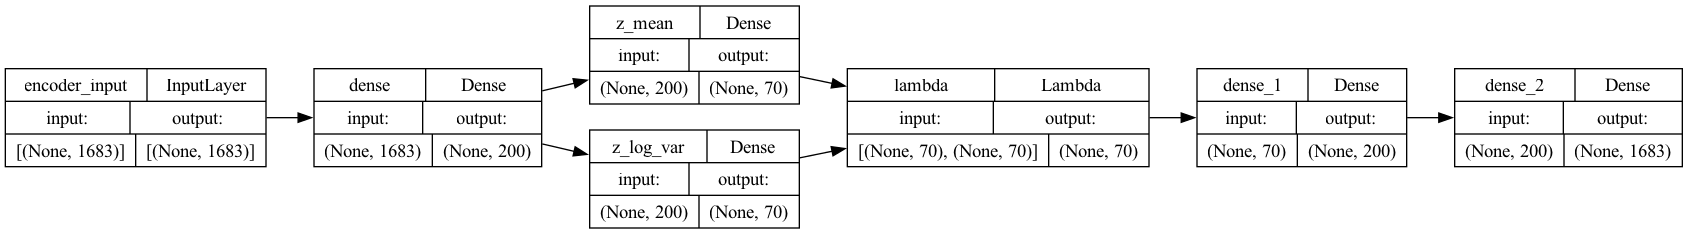

In [5]:
# 연결 그래프 시각화
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Train the VAE

In [5]:
# KL발산(KL divergence)은 한 확률분포가 다른 분포와 얼마나 다른지를 측정하는 방법
# VAE에서 평균이 z_mean이고 분산이 z_log_var인 정규분포가 표준정규분포와 얼마나 다른지 측정 
# 표준정규분포에서 크게 벗어난 z_mean과 z_log_var 변수로 인코딩하는 네트워크에 penalty(규제)를 부여
# 아래와 같이 재구성 손실(reconstruction loss)에 KL발산을 더해야 함 
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
model.add_loss(tf.reduce_mean(kl_loss))

In [6]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
hist = model.fit(train, train, validation_data=(test, test), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/400
10/10 [==============================] - 0s 12ms/step - loss: 1.8426 - val_loss: 0.7841
Epoch 2/400
10/10 [==============================] - 0s 5ms/step - loss: 0.7107 - val_loss: 0.6936
Epoch 3/400
10/10 [==============================] - 0s 6ms/step - loss: 0.6303 - val_loss: 0.6189
Epoch 4/400
10/10 [==============================] - 0s 6ms/step - loss: 0.5659 - val_loss: 0.5363
Epoch 5/400
10/10 [==============================] - 0s 5ms/step - loss: 0.4912 - val_loss: 0.4388
Epoch 6/400
10/10 [==============================] - 0s 6ms/step - loss: 0.4029 - val_loss: 0.3297
Epoch 7/400
10/10 [==============================] - 0s 5ms/step - loss: 0.3191 - val_loss: 0.2309
Epoch 8/400
10/10 [==============================] - 0s 5ms/step - loss: 0.2621 - val_loss: 0.1787
Epoch 9/400
10/10 [==============================] - 0s 5ms/step - loss: 0.2400 - val_loss: 0.1601
Epoch 10/400
10/10 [==============================] - 0s 6ms/step - loss: 0.2265 - val_loss: 0.1547
Epoch 11

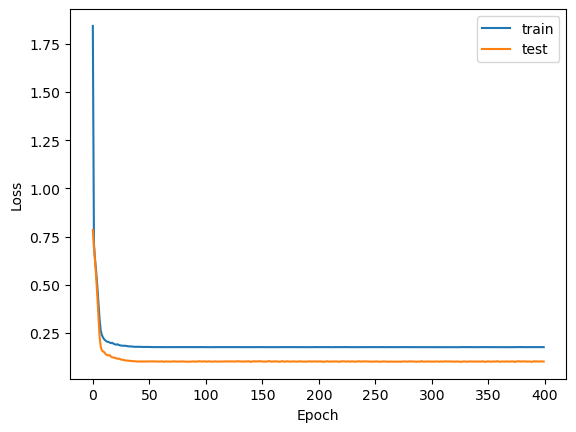

In [7]:
# Plot Learning Curves
plt.plot(hist.history['loss'], label="train")
plt.plot(hist.history['val_loss'], label="test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<font color='tomato'><font color="#CC3D3D"><p>
# End